In [ ]:
!pip install torch

In [ ]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('https://docs.google.com/spreadsheets/d/1I-WycB-n8VvkKrmEvuvA4n-ctcMYyH9o58T783Byt2k/export?format=csv')
df_test = pd.read_csv('https://docs.google.com/spreadsheets/d/17J2k4Cz8FwTGEyQ2mwLLKbFgqbgK9D2a5zfQiuJBt6M/export?format=csv')

In [5]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,#ERROR!
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


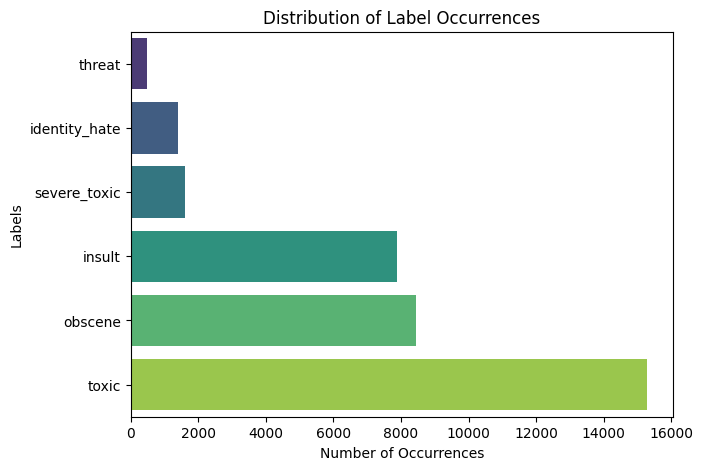

In [7]:
# Visualizing the class distribution of the 'label' column
column_labels = df_train.columns.tolist()[2:]
label_counts = df_train[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
                 y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()

In [8]:
df_train[column_labels].sum().sort_values()

,0
threat,478
identity_hate,1405
severe_toxic,1595
insult,7877
obscene,8449
toxic,15294


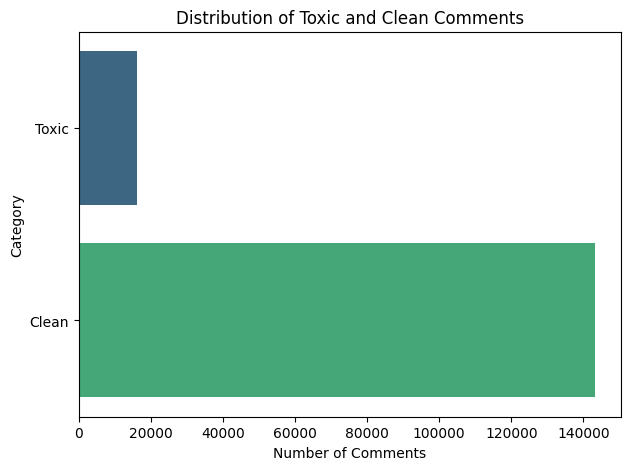

In [9]:
# Create subsets based on toxic and clean comments
train_toxic = df_train[df_train[column_labels].sum(axis=1) > 0]
train_clean = df_train[df_train[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()

In [10]:
# Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state=42)

In [11]:
# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)

In [12]:
# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42)

In [13]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:

        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,

            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,

            # Truncate or pad the comment to 'max_length'
            max_length=max_length,

            # Pad the comment to 'max_length' with zeros if needed
            pad_to_max_length=True,

            # Return attention mask to mask padded tokens
            return_attention_mask=True,

            # Return PyTorch tensors
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [14]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Move model to GPU if available
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [17]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    train_texts,
    train_labels.values
)

# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels.values
)


print('Training Comments :',train_texts.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : (24337,)
Input Ids         : torch.Size([24337, 128])
Attention Mask    : torch.Size([24337, 128])
Labels            : torch.Size([24337, 6])


In [18]:
k = 53
print('Training Comments -->>',train_texts.values[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])

Training Comments -->> They did and have done, on my talk page and on their talk page and most the time im not really doing anything and i always seem to get the finger pointed at me. So what do you expect me to do if someone is uncivil towards me?

Input Ids -->>
 tensor([  101,  2027,  2106,  1998,  2031,  2589,  1010,  2006,  2026,  2831,
         3931,  1998,  2006,  2037,  2831,  3931,  1998,  2087,  1996,  2051,
        10047,  2025,  2428,  2725,  2505,  1998,  1045,  2467,  4025,  2000,
         2131,  1996,  4344,  4197,  2012,  2033,  1012,  2061,  2054,  2079,
         2017,  5987,  2033,  2000,  2079,  2065,  2619,  2003,  4895,  6895,
        14762,  2875,  2033,  1029,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

In [19]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# testing set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# validation set
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101, 16371, 28138,  3538,  1997,  4485,  1010,  6616,  2125,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

In [21]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

In [36]:
from tqdm import tqdm

# Function to Train the Model
def train_model(model, train_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):

        # Set the model to training mode
        model.train()
        # Initialize total loss for the current epoch
        total_loss = 0

        # Loop through the batches in the training data
        for i,batch in enumerate(tqdm(train_loader, colour='green')):
            # batch.set_description(f"Epoch {epoch}")
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [
                    t.to(device) for t in batch]

                outputs = model(
                    input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
        # Print the average loss for the current epoch
        print(
            f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation loss:{val_loss/len(val_loader)}')


# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=3)

100%|██████████| 761/761 [07:54<00:00,  1.60it/s]


Epoch 1, Training Loss: 0.11182117478802076,Validation loss:0.15637662830784566


100%|██████████| 761/761 [07:55<00:00,  1.60it/s]


Epoch 2, Training Loss: 0.09102724896408569,Validation loss:0.16551773778096898


100%|██████████| 761/761 [07:55<00:00,  1.60it/s]


Epoch 3, Training Loss: 0.0701857262319162,Validation loss:0.18621202587612032


###Model Evaluation
let’s evaluate the model now

In [37]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # Use sigmoid for multilabel classification
            predicted_probs_batch = torch.sigmoid(outputs.logits)
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(
        int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')


# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

Accuracy: 0.7009
Precision: 0.8200
Recall: 0.8311


###Save model

In [38]:
# Save the tokenizer and model in the same directory
output_dir = "Saved_model"
# Save model's state dictionary and configuration
model.save_pretrained(output_dir)
# Save tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)

('Saved_model/tokenizer_config.json',
 'Saved_model/special_tokens_map.json',
 'Saved_model/vocab.txt',
 'Saved_model/added_tokens.json')

###Load model

In [39]:
# Load the tokenizer and model from the saved directory
model_name = "Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(
    model_name).to(device)

In [49]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
    user_input = [input_text]

    user_encodings = tokenizer(
        user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(
        user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    labels_list = ['toxic', 'severe_toxic', 'obscene',
                   'threat', 'insult', 'identity_hate']
    result = dict(zip(labels_list, predicted_labels[0]))
    return result

###Prediction

In [62]:
text = 'I will kill you tomorrow!'
predict_user_input(input_text=text)

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 1,
 'insult': 0,
 'identity_hate': 0}

In [59]:
text = 'Lets go to the school together!'
predict_user_input(input_text=text)

{'toxic': 0,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 0,
 'identity_hate': 0}

In [60]:
text = 'You are a piece of shit!'
predict_user_input(input_text=text)

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 1,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

In [61]:
text = 'Normally I would see a green progress bar on a white background'
predict_user_input(input_text=text)

{'toxic': 0,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 0,
 'identity_hate': 0}